In [ ]:
!date

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter

%matplotlib inline

Wed 07 Jun 2023 12:09:54 AM UTC


In [ ]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

In [ ]:
try:
    df_all = pd.read_csv("final.csv")
except:
    df_all = pd.read_csv(pm.get_data("final.csv"))

In [ ]:
df_all.describe()


,year,home_score,away_score,home_tries,away_tries,home_meters,away_meters,home_carries,away_carries,home_def_beaten,...,home_turnovers_won,away_turnovers_won,home_kicks,away_kicks,home_lineouts_won,away_lineouts_won,home_lineouts_lost,away_lineouts_lost,home_penalties,away_penalties
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,...,108.00000,108.000000,108.000000,108.000000,108.000000,108.000000,108.00000,108.000000,108.000000,108.000000
mean,2016.666667,26.657407,23.574074,2.916667,2.666667,425.518519,385.740741,112.037037,100.425926,20.509259,...,5.62963,5.972222,20.935185,21.592593,11.648148,10.935185,1.87037,1.824074,10.018519,11.574074
std,3.281212,11.949396,12.563263,2.009905,1.971763,145.047429,143.689201,31.204758,28.834754,8.330212,...,3.28290,3.402743,8.686947,6.367319,3.100542,3.321618,1.37462,1.496592,3.174023,2.802548
min,2012.000000,8.000000,0.000000,0.000000,0.000000,138.000000,158.000000,52.000000,53.000000,3.000000,...,0.00000,0.000000,7.000000,8.000000,4.000000,3.000000,0.00000,0.000000,3.000000,6.000000
25%,2014.000000,17.750000,14.750000,1.000000,1.000000,313.500000,277.000000,88.750000,80.000000,15.000000,...,4.00000,4.000000,16.000000,17.000000,10.000000,9.000000,1.00000,1.000000,8.000000,10.000000
50%,2016.500000,25.500000,22.000000,2.000000,2.000000,402.000000,359.000000,114.500000,97.000000,19.500000,...,6.00000,6.000000,20.000000,21.000000,12.000000,11.000000,2.00000,2.000000,10.000000,11.000000
75%,2019.000000,32.000000,33.000000,4.000000,4.000000,521.500000,474.750000,129.000000,113.000000,26.000000,...,8.00000,8.000000,25.000000,26.000000,13.000000,13.000000,3.00000,3.000000,12.000000,13.000000
max,2022.000000,73.000000,57.000000,8.000000,9.000000,808.000000,839.000000,215.000000,186.000000,43.000000,...,14.00000,16.000000,80.000000,44.000000,20.000000,19.000000,8.00000,8.000000,21.000000,22.000000


In [ ]:
df_all["difference"] = np.abs(df_all["home_score"] - df_all["away_score"])


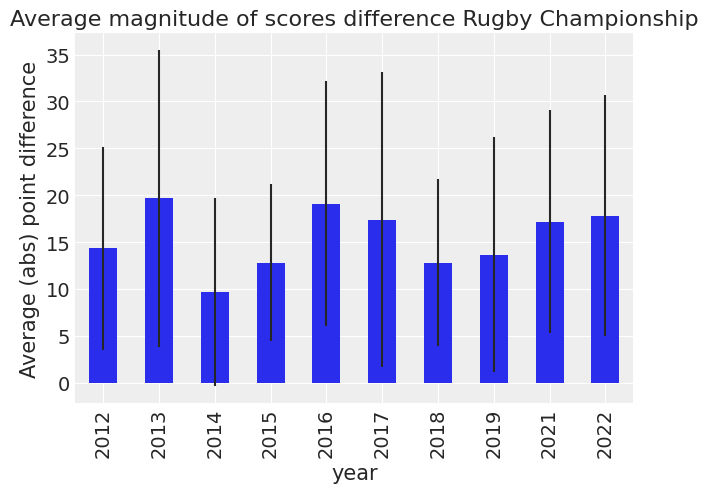

In [ ]:
(
    df_all.groupby("year")["difference"]
    .mean()
    .plot(
        kind="bar",
        title="Average magnitude of scores difference Rugby Championship",
        yerr=df_all.groupby("year")["difference"].std(),
    )
    .set_ylabel("Average (abs) point difference")
);

In [ ]:
df_all["difference_non_abs"] = df_all["home_score"] - df_all["away_score"]


In [ ]:
df_all.pivot_table("difference_non_abs", "home_team", "year")


year,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022
home_team,,,,,,,,,,
Argentina,-15.000000,-20.000000,-6.333333,-25.0,-9.666667,-20.333333,-5.333333,-18.5,-19.000000,0.000000
Australia,1.000000,-14.333333,2.666667,6.0,-4.000000,1.666667,-8.000000,13.5,5.000000,-3.333333
New Zealand,16.000000,13.333333,18.000000,21.0,27.666667,26.666667,16.000000,0.0,25.333333,23.000000
South Africa,9.333333,23.000000,9.000000,-9.5,-9.000000,7.000000,7.333333,18.0,6.666667,7.666667


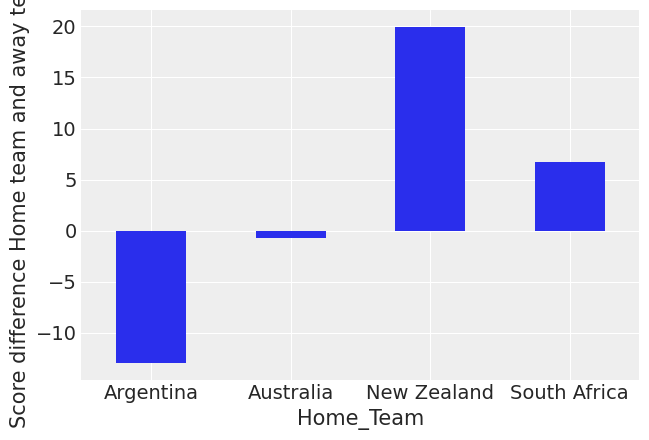

In [ ]:
(
    df_all.pivot_table("difference_non_abs", "home_team")
    .rename_axis("Home_Team")
    .plot(kind="bar", rot=0, legend=False)
    .set_ylabel("Score difference Home team and away team")
);

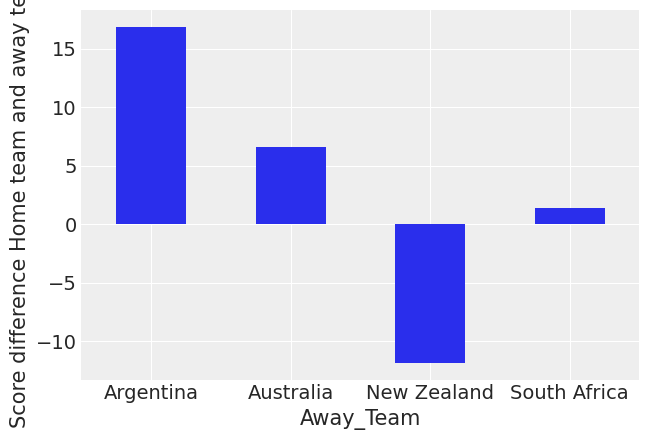

In [ ]:
(
    df_all.pivot_table("difference_non_abs", "away_team")
    .rename_axis("Away_Team")
    .plot(kind="bar", rot=0, legend=False)
    .set_ylabel("Score difference Home team and away team")
);

In [ ]:
plt.rcParams["figure.constrained_layout.use"] = True
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)
coords = {"team": teams}

In [ ]:
with pm.Model(coords=coords) as model:
    # constant data
    home_team = pm.ConstantData("home_team", home_idx, dims="match")
    away_team = pm.ConstantData("away_team", away_idx, dims="match")

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=1)
    sd_att = pm.HalfNormal("sd_att", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic("atts", atts_star - pt.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - pt.mean(defs_star), dims="team")
    home_theta = pt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = pt.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims=("match"),
    )
    trace = pm.sample(1000, tune=1500, cores=4)

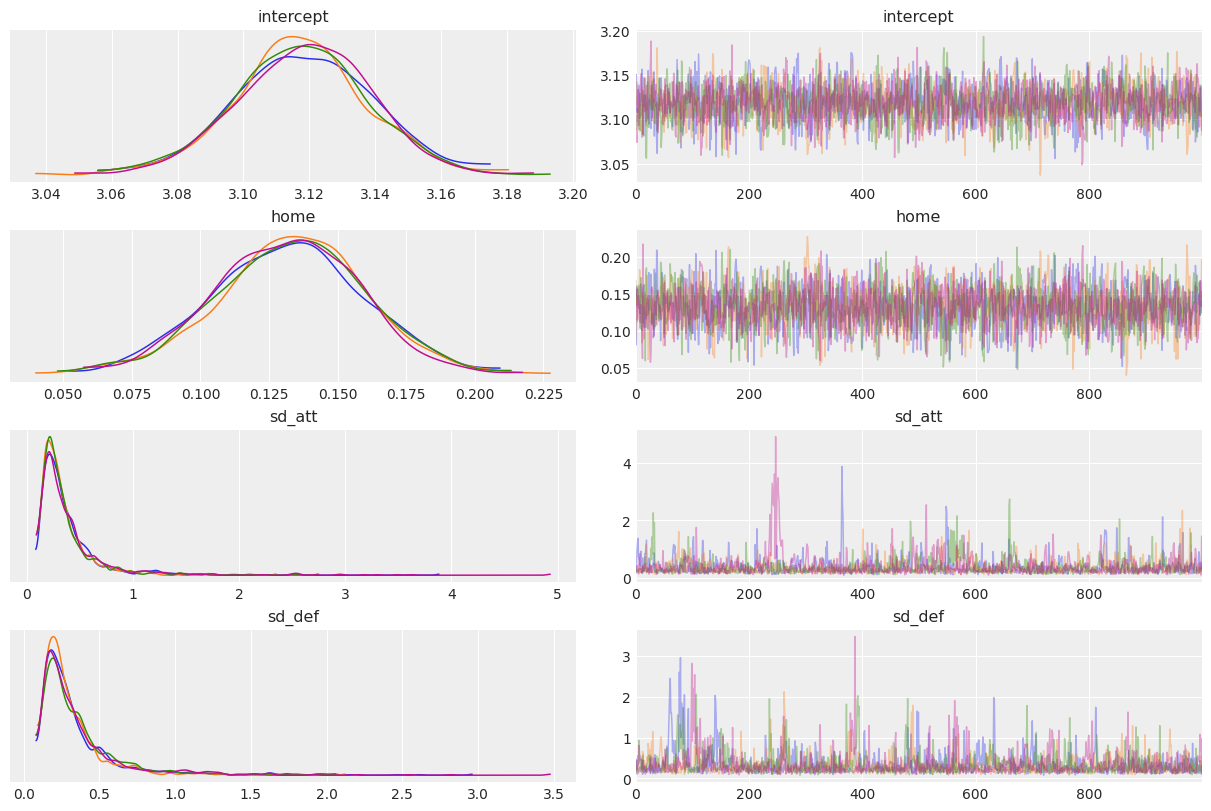

In [ ]:
az.plot_trace(trace, var_names=["intercept", "home", "sd_att", "sd_def"], compact=False);


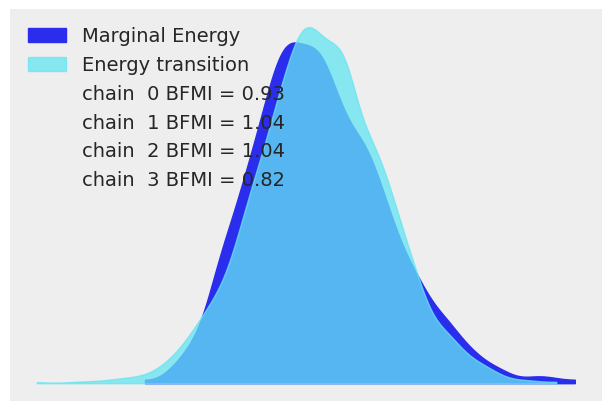

In [ ]:
az.plot_energy(trace, figsize=(6, 4));


In [ ]:
class TeamLabeller(az.labels.BaseLabeller):
    def make_label_flat(self, var_name, sel, isel):
        sel_str = self.sel_to_str(sel, isel)
        return sel_str

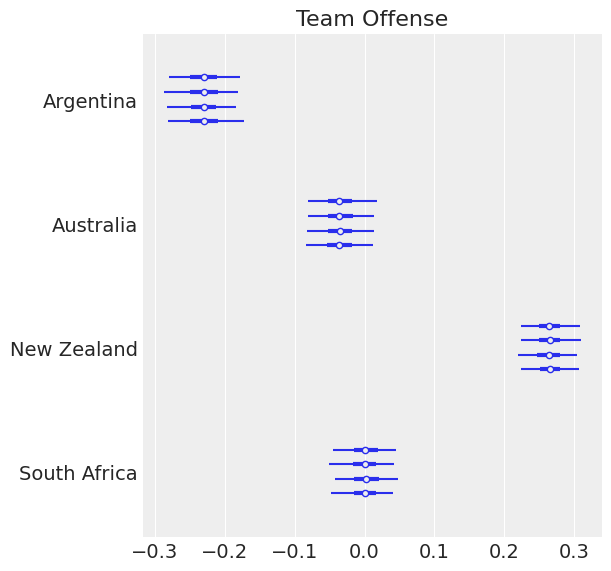

In [ ]:
ax = az.plot_forest(trace, var_names=["atts"], labeller=TeamLabeller())
ax[0].set_title("Team Offense");

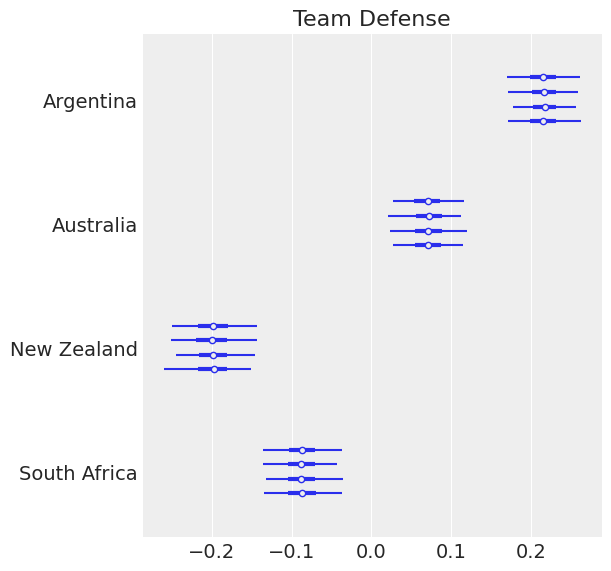

In [ ]:
ax = az.plot_forest(trace, var_names=["defs"], labeller=TeamLabeller())
ax[0].set_title("Team Defense");

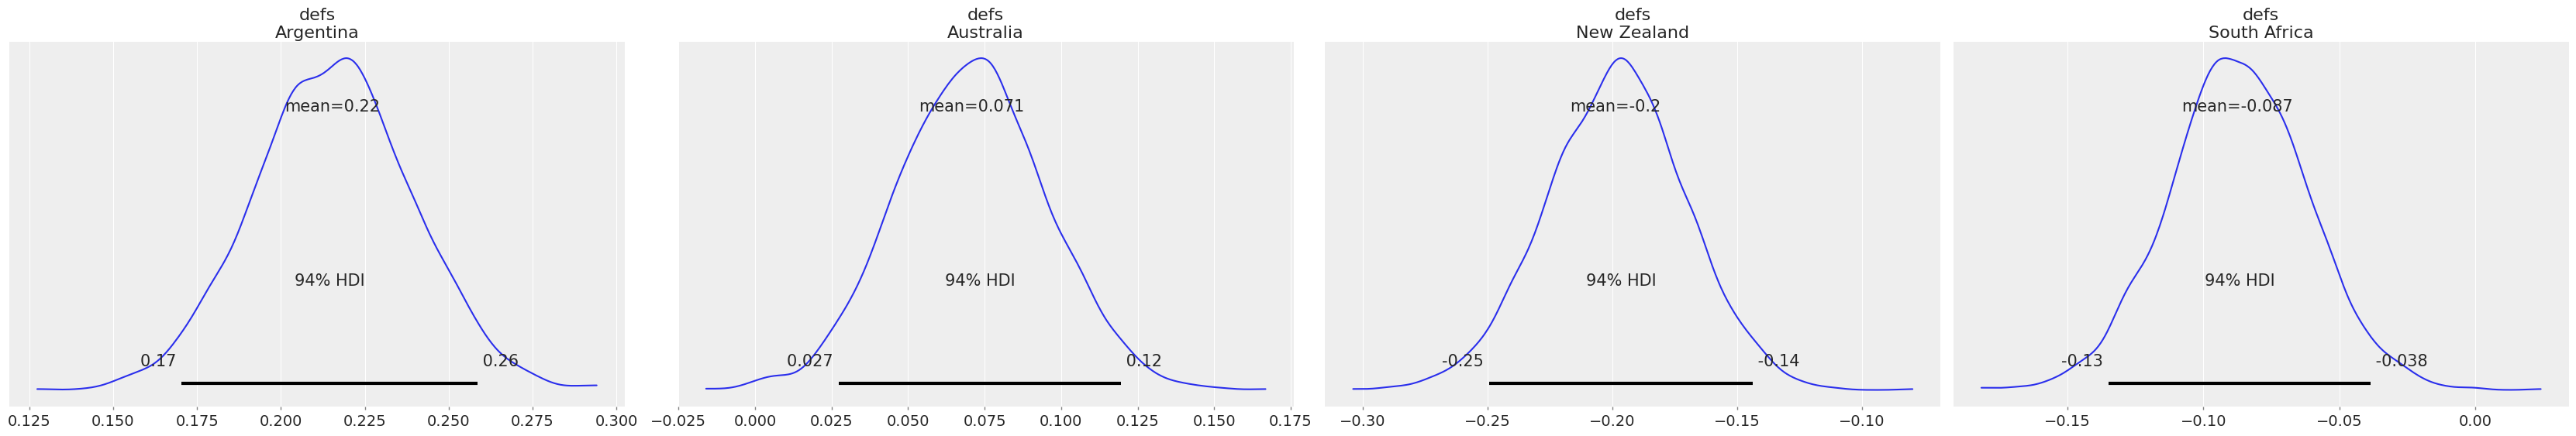

In [ ]:
az.plot_posterior(trace, var_names=["defs"]);

In [ ]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
pp = trace.posterior_predictive
const = trace.constant_data
team_da = trace.posterior.team

In [ ]:
# fmt: off
pp["home_win"] = (
    (pp["home_points"] > pp["away_points"]) * 4     # home team wins and gets 3 points
    + (pp["home_points"] == pp["away_points"]) * 2  # tie -> home team gets 2 points
)
pp["away_win"] = (
    (pp["home_points"] < pp["away_points"]) * 4
    + (pp["home_points"] == pp["away_points"]) * 2
)

In [ ]:
groupby_sum_home = pp.home_win.groupby(team_da[const.home_team]).sum()
groupby_sum_away = pp.away_win.groupby(team_da[const.away_team]).sum()

pp["teamscores"] = groupby_sum_home + groupby_sum_away

In [ ]:
from xarray_einstats.stats import rankdata

pp["rank"] = rankdata(-pp["teamscores"], dims="team", method="min")
pp[["rank"]].sel(team="Argentina")

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    team     <U9 'Argentina'
Data variables:
    rank     (chain, draw) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
Attributes:
    created_at:                 2023-06-07T00:13:44.665735
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.1.2

In [ ]:
from xarray_einstats.numba import histogram

bin_edges = np.arange(5) + 0.5
data_sim = (
    histogram(pp["rank"], dims=("chain", "draw"), bins=bin_edges, density=True)
    .rename({"bin": "rank"})
    .assign_coords(rank=np.arange(4) + 1)
)

In [ ]:
idx_dim, col_dim = data_sim.dims
sim_table = pd.DataFrame(data_sim, index=data_sim[idx_dim], columns=data_sim[col_dim])

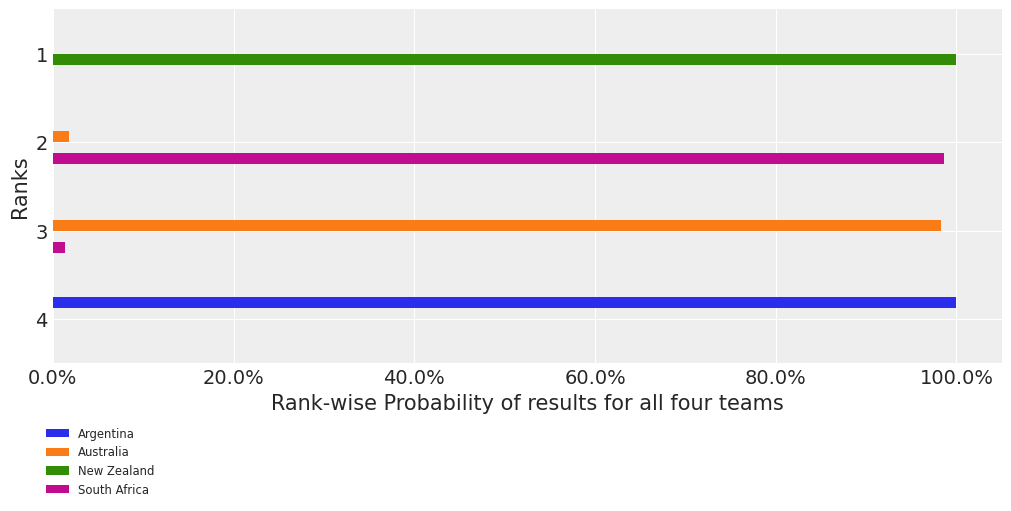

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sim_table.T.plot(kind="barh", ax=ax)
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.1%}"))
ax.set_xlabel("Rank-wise Probability of results for all four teams")
ax.set_yticklabels(np.arange(1, 5))
ax.set_ylabel("Ranks")
ax.invert_yaxis()
ax.legend(fontsize="small", loc='upper center', bbox_to_anchor=(0.05,-0.15));